In [2]:
!pip install smdebug


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install scikit-image


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


##

In [2]:
import matplotlib.pyplot as plt

In [3]:
import sagemaker
import boto3
import os

from skimage.io import imread
from skimage import img_as_ubyte
import numpy as np

In [4]:
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

from sagemaker.pytorch import PyTorch
from sagemaker.pytorch.model import PyTorchModel

In [5]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
import IPython

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-03-30 12:16:59.329 pytorch-1-13-cpu-py39-ml-m5-large-e240dbf4b804946d7c5723319b3e:2298 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [6]:
bucket= 'udacity-mle-capstone'
print("Default Bucket: {}".format(bucket))
region = 'us-east-2'
print("AWS Region: {}".format(region))
role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: udacity-mle-capstone
AWS Region: us-east-2
RoleArn: arn:aws:iam::085616114435:role/service-role/AmazonSageMaker-ExecutionRole-20221221T205295


## Train initial model with profiling and debugging

In [9]:
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

In [12]:
estimator = PyTorch(
    entry_point='train_model.py',
    role=role,
    instance_count=1,
    instance_type="ml.m5.4xlarge",
    framework_version="1.8",
    #profiler_config=profiler_config,
    #debugger_hook_config=debugger_config,
    #rules=rules,
    py_version="py36",
    source_dir="code"
)

In [13]:
estimator.fit({'train':'s3://udacity-mle-capstone/train/',
               'test':'s3://udacity-mle-capstone/test/',
               'meta':'s3://udacity-mle-capstone/meta/'
              }, 
              wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-03-30-11-53-13-318


2023-03-30 11:53:14 Starting - Starting the training job...
2023-03-30 11:53:28 Starting - Preparing the instances for training...
2023-03-30 11:54:10 Downloading - Downloading input data......
2023-03-30 11:55:00 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-30 11:55:30,567 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-30 11:55:30,570 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-30 11:55:30,578 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-30 11:55:30,580 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-03-30 11:55:30,734 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.6 -m pip install -r requirements.txt
2

In [14]:
estimator.jobs[-1].describe()

{'TrainingJobName': 'pytorch-training-2023-03-30-11-53-13-318',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-2:085616114435:training-job/pytorch-training-2023-03-30-11-53-13-318',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-2-085616114435/pytorch-training-2023-03-30-11-53-13-318/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"pytorch-training-2023-03-30-11-53-13-318"',
  'sagemaker_program': '"train_model.py"',
  'sagemaker_region': '"us-east-2"',
  'sagemaker_submit_directory': '"s3://sagemaker-us-east-2-085616114435/pytorch-training-2023-03-30-11-53-13-318/source/sourcedir.tar.gz"'},
 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-2.amazonaws.com/pytorch-training:1.8-cpu-py36',
  'TrainingInputMode': 'File',
  'EnableSageMakerMetricsTimeSeries': True},
 'RoleArn': 'arn:aws:iam::085616114435:role/service-role/A

## Hyperparameter tuning

In [15]:
estimator = PyTorch(
    entry_point='train_model.py',
    role=role,
    instance_count=1,
    instance_type="ml.m5.4xlarge",
    framework_version="1.8",
    py_version="py36",
    source_dir="code"
)

In [16]:
hyperparameter_ranges = {
    "train-batch-size": CategoricalParameter([64, 128]),
    "lr": CategoricalParameter([0.1, 1.0])
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=4,
    objective_type=objective_type
)

In [17]:
tuner.fit({'train':'s3://udacity-mle-capstone/train/',
               'test':'s3://udacity-mle-capstone/test/',
               'meta':'s3://udacity-mle-capstone/meta/'
              }, 
              wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-230330-1203


........................................................................................!


In [18]:
tuner.best_training_job()

'pytorch-training-230330-1203-004-0e857971'

In [19]:
best_estimator = tuner.best_estimator()


2023-03-30 12:09:29 Starting - Preparing the instances for training
2023-03-30 12:09:29 Downloading - Downloading input data
2023-03-30 12:09:29 Training - Training image download completed. Training in progress.
2023-03-30 12:09:29 Uploading - Uploading generated training model
2023-03-30 12:09:29 Completed - Resource retained for reuse


In [20]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"average test loss"',
 'lr': '"1.0"',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-03-30-12-03-00-346"',
 'sagemaker_program': '"train_model.py"',
 'sagemaker_region': '"us-east-2"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-2-085616114435/pytorch-training-2023-03-30-12-03-00-346/source/sourcedir.tar.gz"',
 'train-batch-size': '"128"'}

In [21]:
best_estimator.model_data

's3://sagemaker-us-east-2-085616114435/pytorch-training-230330-1203-004-0e857971/output/model.tar.gz'

## Deploy to endpoint and run inference on pairs of images

In [9]:
#'s3://sagemaker-us-east-2-085616114435/pytorch-training-230330-1203-004-0e857971/output/model.tar.gz'

estimator_trained = PyTorchModel(
    model_data = 's3://sagemaker-us-east-2-085616114435/pytorch-training-230330-1203-004-0e857971/output/model.tar.gz',#best_estimator.model_data,
    entry_point='inference.py',
    framework_version="1.8",
    py_version="py36",
    source_dir="code",
    role=role
)

In [10]:
predictor=estimator_trained.deploy(initial_instance_count=1, 
                           instance_type="ml.m5.large")

------!

In [11]:
img1 = img_as_ubyte(imread('/root/udacity-mle-capstone/project/sign_data/test/050/01_050.png', as_gray=True))
img2 = img_as_ubyte(imread('/root/udacity-mle-capstone/project/sign_data/test/050/02_050.png', as_gray=True))
img3 = img_as_ubyte(imread('/root/udacity-mle-capstone/project/sign_data/test/050_forg/02_0204050.PNG', as_gray=True))

In [12]:
response_real = predictor.predict(np.array([img1, img2], dtype='object'))
response_forged = predictor.predict(np.array([img1, img3], dtype='object'))

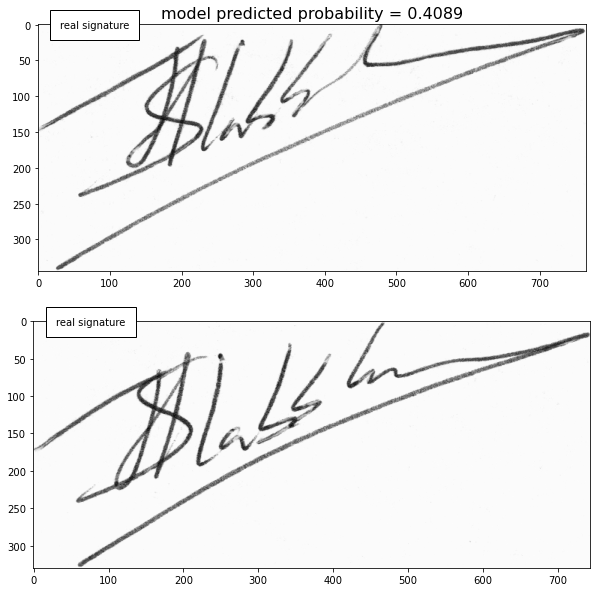

In [13]:
fig, axs = plt.subplots(2, figsize=(10, 10))
ax0,ax1 = axs
ax0.imshow(img1, cmap='binary_r', label='real')
ax1.imshow(img2, cmap='binary_r')
ax0.set_title(f'model predicted probability = {response_real:.4f}', size=16)
ax0.text(30, 5, 'real signature', bbox={'facecolor': 'white', 'pad': 10})
ax1.text(30, 5, 'real signature', bbox={'facecolor': 'white', 'pad': 10});

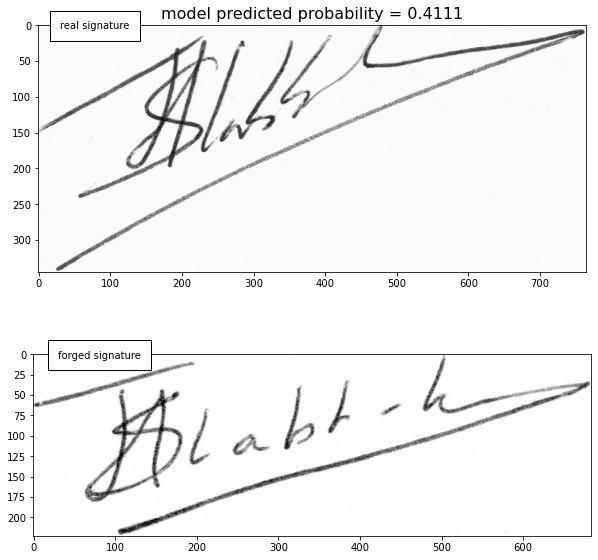

In [14]:
fig, axs = plt.subplots(2, figsize=(10, 10))
ax0,ax1 = axs
ax0.imshow(img1, cmap='binary_r')
ax1.imshow(img3, cmap='binary_r')
ax0.set_title(f'model predicted probability = {response_forged:.4f}', size=16)
ax0.text(30, 5, 'real signature', bbox={'facecolor': 'white', 'pad': 10})
ax1.text(30, 5, 'forged signature', bbox={'facecolor': 'white', 'pad': 10});

In [15]:
import pandas as pd
from tqdm import tqdm

In [16]:
test_df = pd.read_csv('/root/udacity-mle-capstone/project/sign_data/test_data.csv', header=0, names=['img_path_real', 'img_path_forged', 'label'])
test_df['img_path_real'] = test_df['img_path_real'].apply(lambda x : f'/root/udacity-mle-capstone/project/sign_data/test/{x}')
test_df['img_path_forged'] = test_df['img_path_forged'].apply(lambda x : f'/root/udacity-mle-capstone/project/sign_data/test/{x}')

In [27]:
y_pred = []
y = []
for index,row in tqdm(test_df.sample(frac=1.0).reset_index(drop=True).iterrows()):
    if index>100:
        break
    try:
        img1 = img_as_ubyte(imread(row['img_path_real'], as_gray=True))
        img2 = img_as_ubyte(imread(row['img_path_forged'], as_gray=True))
        y_pred.append(predictor.predict(np.array([img1, img2], dtype='object'))) 
        y.append(row['label'])
    except:
        pass

101it [00:13,  7.67it/s]


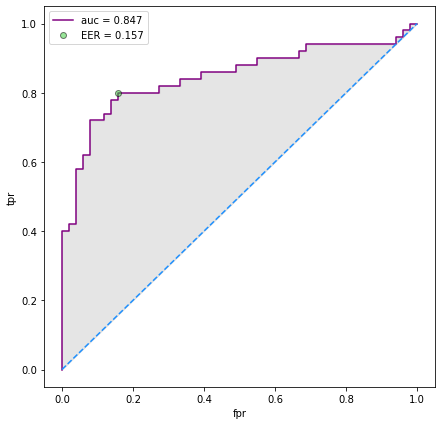

In [28]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y, y_pred, pos_label=1)
fnr = 1 - tpr
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
eer_idx = np.nanargmin(np.abs(threshold - eer_threshold))
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(fpr, tpr, color='purple', label=f'auc = {roc_auc:.3f}')
ax.plot(fpr, fpr, '--', c='dodgerblue')
ax.fill_between(fpr, fpr, tpr, color='grey', alpha=0.2)
#ax.axvline(fpr[eer_idx], color='limegreen')
#ax.axhline(tpr[eer_idx], color='limegreen')
ax.plot(fpr[eer_idx],tpr[eer_idx],'o', mec='k', color='limegreen', alpha=0.5, label=f'EER = {EER:.3f}')
ax.legend()
ax.set_xlabel('fpr')
ax.set_ylabel('tpr');

## Cleanup: delete endpoint

In [29]:
predictor.delete_endpoint()